In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
import seaborn as sns
drive_path = r"\\NERFHF01/djnerf1/VEIDB/"
# data_path = r"Y:\Data"
data_path =r"W:\Data/"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
import sys
sys.path.append("..")

In [3]:
from importlib import reload  

import DeNeCo
DeNeCo = reload(DeNeCo)

In [4]:
key = {'experiment_id': '01232', 'session_id': '20200328a', 'subsession_type': 'EXPA'}
clusters = (subsess_spikes_table & key).fetch1('clusters')

NameError: name 'subsess_spikes_table' is not defined

In [5]:
clusters

NameError: name 'clusters' is not defined

In [6]:
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.gridspec import GridSpec
import matplotlib

import seaborn as sb
sb.set_style('white')

In [7]:
def filter_clusters(clusters, cluster_annot, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None, colored=False, color_palette=None, visualize_depth=False, cluster_depths=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        if visualize_depth:
            depth = cluster_depths[cluster]
        else:
            depth = cluster
            
        if colored:
            color = color_palette[random.randint(0, len(color_palette)-1)]
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[color]) # SCATTER PLOT
        else:
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[(0, 0, 0, 0.4)]) # SCATTER PLOT
    
    ax.set_ylabel('depth')
    ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)
            
def spikes_2_spikecounts(clusters, start, end, binsize=30):
    """Excludes neurons that don't fire"""
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = np.float32(fr)
    return fr_clusters

def plot_spikecounts_mean(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


['2P', 'SCEphys', 'VEIDB', 'VEIDBOpenfield', 'mysql', 'performance_schema', 'sys', 'test', 'tutorial']


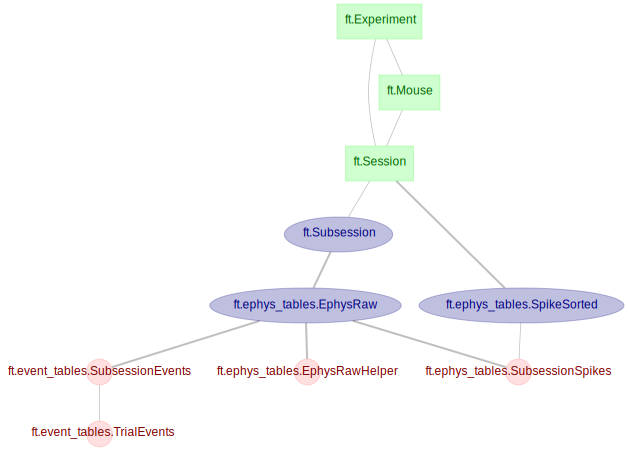

In [8]:
print(dj.list_schemas())
dj.Di(ft.schema)

In [9]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()

In [6]:
import random
color_palette = sns.color_palette("tab10")
#sns.color_palette("hls", 5)
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

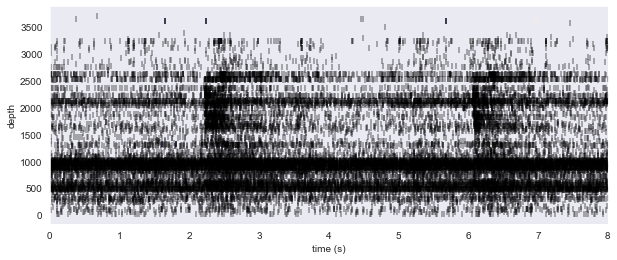

In [44]:
data = []
clusters_good = filter_clusters(clusters, cluster_annot, annot=['good'])

fig, ax = plt.subplots(figsize=(10, 4))
plot_spike_raster(clusters_good, start=30000*0, end=30000*8, ax=ax, event_times=None, colored=False, color_palette=color_palette, visualize_depth=True, cluster_depths=cluster_info['depth'])
plt.xlim(0, 8)
# for trigger in subsess_triggers[7]:
#     ax.axvline(trigger/30000, c='r')
plt.savefig(r'images\spikes_SC.png', dpi=200)
plt.show()

In [45]:
[(c, d) for c, d in cluster_info['depth'].items() if c in clusters_good and d < 2200 and d > 1900]

[(153, 1920.0),
 (190, 1980.0),
 (196, 2000.0),
 (203, 2000.0),
 (208, 2020.0),
 (209, 2040.0),
 (222, 2040.0),
 (227, 2040.0),
 (235, 2060.0),
 (250, 2080.0),
 (256, 2080.0),
 (265, 2100.0),
 (272, 2120.0),
 (273, 2120.0),
 (281, 2120.0),
 (286, 2140.0),
 (293, 2140.0)]

In [46]:
def sort_clusters_by_depth(clusters, depth):
    clusters_sorted_by_depth = sorted(depth, key=depth.get)
    return clusters_sorted_by_depth, [depth[c] for c in clusters_sorted_by_depth]

clusters_sorted_by_depth, clusters_sorted_by_depth_depths = sort_clusters_by_depth(clusters_good, cluster_info['depth'])
clusters_sorted_by_depth.reverse()
clusters_sorted_by_depth_depths.reverse()

In [47]:
clusters_sorted_by_depth_depths[140:148]
# clusters_sorted_by_depth_depths[-148:-140]

[2680.0, 2660.0, 2640.0, 2640.0, 2620.0, 2620.0, 2620.0, 2600.0]

In [48]:
clusters_sorted_by_depth_depths

[3800.0,
 3780.0,
 3760.0,
 3720.0,
 3720.0,
 3700.0,
 3700.0,
 3680.0,
 3680.0,
 3660.0,
 3660.0,
 3660.0,
 3640.0,
 3640.0,
 3640.0,
 3620.0,
 3620.0,
 3620.0,
 3600.0,
 3600.0,
 3600.0,
 3580.0,
 3580.0,
 3580.0,
 3560.0,
 3560.0,
 3560.0,
 3560.0,
 3540.0,
 3540.0,
 3500.0,
 3480.0,
 3480.0,
 3460.0,
 3440.0,
 3400.0,
 3400.0,
 3380.0,
 3380.0,
 3360.0,
 3360.0,
 3360.0,
 3340.0,
 3340.0,
 3340.0,
 3320.0,
 3320.0,
 3300.0,
 3300.0,
 3300.0,
 3280.0,
 3280.0,
 3260.0,
 3260.0,
 3260.0,
 3240.0,
 3240.0,
 3240.0,
 3240.0,
 3240.0,
 3240.0,
 3240.0,
 3240.0,
 3220.0,
 3220.0,
 3200.0,
 3200.0,
 3200.0,
 3180.0,
 3180.0,
 3180.0,
 3160.0,
 3160.0,
 3160.0,
 3140.0,
 3140.0,
 3140.0,
 3140.0,
 3140.0,
 3140.0,
 3120.0,
 3120.0,
 3100.0,
 3100.0,
 3100.0,
 3100.0,
 3080.0,
 3080.0,
 3080.0,
 3080.0,
 3060.0,
 3060.0,
 3060.0,
 3060.0,
 3040.0,
 3040.0,
 3040.0,
 3020.0,
 3000.0,
 3000.0,
 3000.0,
 2980.0,
 2980.0,
 2960.0,
 2960.0,
 2960.0,
 2940.0,
 2940.0,
 2920.0,
 2920.0,
 2920.0,
 

- Aggregate neurons from multiple sessions
- Plot individual neuron stats for each session
- Cluster sSC neurons 

## Basic stats

In [35]:
for c, spiketimes in clusters_good.items():
    isis = np.diff(spiketimes)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.hist(isis, bins=50)
    ax.set_title(c)
    plt.show()

AttributeError: 'list' object has no attribute 'items'

# Plot all neurons

In [32]:
""" Load all data """
# session_key = {'experiment_id': '01231', 'session_id': '20200327a'}
session_key = {'experiment_id': '01232', 'session_id': '20200328a'}
# session_key = {'experiment_id': '01261', 'session_id': '20200327f'}
# session_key = {'experiment_id': '01247', 'session_id': '20200328e'}

figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images", f"neurons_{session_key['experiment_id']}_{session_key['session_id']}")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)

cluster_info = (sorted_table & session_key).fetch1('cluster_info')
clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']

stims_vis = ['EXPA', 'DIMM', 'CHPE', 'EXPW']
# , 'EXPN', 'EXPB', 'DIMK'
stims_dict = {}
for stim in stims_vis:
    print(stim)
    stims_dict[stim] = {}
    stims_dict[stim]['key'] = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
    stims_dict[stim]['clusters'] = (subsess_spikes_table & stims_dict[stim]['key']).fetch1('clusters')
    stims_dict[stim]['starts'], stims_dict[stim]['ends'], stims_dict[stim]['triggers'] = (subsess_events_table & stims_dict[stim]['key']).fetch1('trials_starts', 'trials_ends', 'subsession_triggers')

# key_expa = {'subsession_id': 'EXPA_0002', 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
# key_dimm = {'subsession_id': 'DIMM_0004', 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
# key_chpe = {'subsession_id': 'CHPE_0009', 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}

# clusters_expa = (subsess_spikes_table & key_expa).fetch1('clusters')
# clusters_dimm = (subsess_spikes_table & key_dimm).fetch1('clusters')
# clusters_chpe = (subsess_spikes_table & key_chpe).fetch1('clusters')

# stims_dict = {'starts': {}, 'ends': {}, 'triggers': {}}
# EXPA_starts, EXPA_ends, EXPA_triggers = (subsess_events_table & key_expa).fetch1('trials_starts', 'trials_ends', 'subsession_triggers')
# DIMM_starts, DIMM_ends, DIMM_triggers = (subsess_events_table & key_dimm).fetch1('trials_starts', 'trials_ends', 'subsession_triggers')
# CHPE_starts, CHPE_ends, CHPE_triggers = (subsess_events_table & key_chpe).fetch1('trials_starts', 'trials_ends', 'subsession_triggers')

EXPA
DIMM
CHPE
EXPW
EXPN
EXPB
DIMK


DataJointError: fetch1 should only return one tuple. 0 tuples were found

In [27]:
(trial_events_table & stims_dict['EXPA']['key']).fetch('events')

array([(63932, 73427, 88933), (179432, 188925, 204433),
       (294932, 304428, 319931), (410429, 419924, 435431),
       (525923, 535424, 550930), (641428, 650923, 666424),
       (756928, 766422, 781929), (872427, 881922, 897427),
       (987926, 997425, 1012927), (1103426, 1112921, 1128426),
       (63936, 73430, 88936), (179436, 188929, 204424),
       (294935, 304429, 319935), (410433, 419929, 435433),
       (525936, 535428, 550934), (641425, 650932, 666433),
       (756932, 766426, 781932), (872430, 881925, 897430),
       (987929, 997425, 1012930), (1103429, 1112924, 1128431),
       (63934, 106932, 122421), (212936, 255926, 271423),
       (361931, 404926, 420432), (510930, 553924, 569431),
       (659924, 702924, 718428), (808929, 851922, 867428),
       (957928, 1000909, 1016419), (1106927, 1149921, 1165426),
       (1255927, 1298920, 1314425), (1404924, 1447906, 1463416),
       (63936, 106929, 122424), (212934, 255933, 271421),
       (361933, 404928, 420421), (510932, 553

KeyError: 'EXPK'

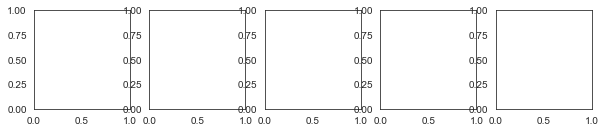

In [30]:
padding = 30000*(0.1)
binsize = 25
smooth_sigma = 1
n_trials = 4 
bins_per_sec = 1000/binsize
plt.rcParams.update({'font.family': 'Arial'})

widths = [1, 1, 1, 1, 1]
cmap_viridis = matplotlib.cm.get_cmap('viridis')
# print(cmap.colors)
# cmap.colors = cmap.colors[len(cmap.colors)//2:]
cmap = matplotlib.colors.ListedColormap(cmap_viridis.colors[::2], name='myColorMap', N=len(cmap_viridis.colors)//2)




for c in clusters_good:
    c_depth = cluster_info['depth'][c]
    
#     fig, axs = plt.subplots(1, 4, figsize=(14,3))
    fig = plt.figure(constrained_layout=False, figsize=(10, 4))
    gs = GridSpec(2, 5, figure=fig, width_ratios=widths)
    spike_raster_ax = fig.add_subplot(gs[0, 0])
    stims_dict['EXPA']['ax'] = fig.add_subplot(gs[0,1])
    stims_dict['DIMM']['ax'] = fig.add_subplot(gs[0,2], sharey=stims_dict['EXPA']['ax'])
    stims_dict['EXPW']['ax'] = fig.add_subplot(gs[0,3], sharey=stims_dict['EXPA']['ax'])
    stims_dict['EXPK']['ax'] = fig.add_subplot(gs[0,4], sharey=stims_dict['EXPA']['ax'])
    stims_dict['CHPE']['ax'] = fig.add_subplot(gs[1,:])
    fig.suptitle(f"{c}, depth: {c_depth}", fontsize=10)
    
    for stim, d in stims_dict.items():
        trials = []
        trial_lengths = []
        for start, end in zip(d['starts'], d['ends']):
            spikecounts = spikes_2_spikecounts({c: d['clusters'].get(c, np.array([]))}, start=start-padding, end=end+padding, binsize=binsize)[c]
            trials.append(smooth_spikecounts(spikecounts, sigma=smooth_sigma))
            trial_lengths.append(len(spikecounts))
        min_trial_length = min(trial_lengths)
        stims_dict[stim]['trials'] = trials
        stims_dict[stim]['min_trial_length'] = min_trial_length
        stims_dict[stim]['trials_np'] = np.array([trial[:min_trial_length] for trial in trials]) # Assumes that all trials have the same length!!

    
    """ Visualization """
    all_good_clusters = {c:v for c, v in stims_dict['EXPA']['clusters'].items() if c in clusters_good}
    # uncomment to get spike raster!
#     plot_spike_raster(all_good_clusters, start=0, end=30000*10, ax=spike_raster_ax, event_times=None, colored=False, color_palette=None, visualize_depth=True, cluster_depths=cluster_info['depth'])
#     if c in all_good_clusters:
#         cl_spike_times_sub = all_good_clusters[c][(all_good_clusters[c] >= 0) & (all_good_clusters[c] < 30000*10)]
#         spike_raster_ax.scatter(np.array(cl_spike_times_sub)/30000, np.ones_like(cl_spike_times_sub)*c_depth, marker='|', c='r') # SCATTER PLOT

#         axs[0].plot(spikecounts, c='b')
    for idx, (stim, d) in enumerate(stims_dict.items()):
        trials_np = d['trials_np']
        n_trials = len(trials_np)
        for i, trial in enumerate(trials_np[:n_trials]):
#         print(((len(expa_trials_np)-i)/len(expa_trials_np))/3 + 2/3)
            n_trials = len(trials_np)
#             d['ax'].plot(np.arange(0, len(trial))*binsize/1000, trial*bins_per_sec, c=cmap((n_trials-i)/(n_trials)), alpha=0.8)#, alpha=(((n_trials)-i)/n_trials)/3 + 1/3)
            d['ax'].plot(np.arange(0, len(trial))*binsize/1000, trial*bins_per_sec, c='gray', alpha=0.4)#, alpha=(((n_trials)-i)/n_trials)/3 + 1/3)

        d['ax'].set_title(stim, fontsize=10)
        mean_response = np.mean(trials_np[:n_trials], axis=0)*bins_per_sec
        d['ax'].plot(np.arange(0, len(mean_response))*binsize/1000, mean_response, c='k', alpha=1, linewidth=3)
#         print(d['triggers'])
        for trigger in d['triggers'][7][:3]:
#             print(trigger)
            d['ax'].axvline((trigger-d['triggers'][7][0])/30000+(padding/(30000)), c='r', alpha=1, linewidth=2)
            
#         d['ax'].tick_params(labelsize=ticks_font['fontsize'])

        d['ax'].spines['top'].set_visible(False)
        d['ax'].spines['right'].set_visible(False)
        d['ax'].set(xlim=[0,None])
#         d['ax'].set(xticks=[0, 2, 4])
#         d['ax'].axvspan(0, 1, alpha=0.1, color='royalblue')
#         d['ax'].tick_params(axis='x', length=3*sc, width=1*sc, pad=3*sc)
#         d['ax'].tick_params(axis='y', length=3*sc, width=1*sc, pad=3*sc)
        for axis in ['top', 'bottom', 'left', 'right']:
            d['ax'].spines[axis].set_linewidth(2)

#         d['ax'].axvline((padding/(30000)), c='r', alpha=1, linewidth=1)
#         d['ax'].axvline((len(trials_np[0]) - (padding/(binsize*30)))*binsize/1000, c='r', alpha=1, linewidth=1) # slightly incorrect since trials might have been shortened

    sb.despine(trim=False)

    plt.tight_layout()
    plt.savefig(os.path.join(figures_folder, "extra", f"{c_depth}_{c}.png"), dpi=100)

    plt.show()

    
    
# for c, spiketimes in clusters_good.items():
#     isis = np.diff(spiketimes)
#     fig, ax = plt.subplots(1, 1, figsize=(3, 3))
#     ax.hist(isis, bins=50)
#     ax.set_title(c)
#     plt.show()

In [125]:
cluster_info

{'amp': {0: 41.25229645,
  1: 35.05923462,
  2: 23.44447708,
  3: 37.09415436,
  4: 33.26468658,
  5: 15.80444908,
  6: 28.1006813,
  7: 48.3860321,
  8: 77.0788269,
  9: 27.6462059,
  10: 33.67474365,
  11: 31.79704094,
  12: 13.29590607,
  14: 39.50976181,
  15: 26.24170685,
  16: 38.66893005,
  17: 28.11956024,
  18: 16.29823303,
  19: 35.34723663,
  20: 63.60873032,
  21: 20.32364464,
  22: 30.67101288,
  23: 107.16990662,
  24: 29.70629311,
  25: 13.77715683,
  28: 38.26150894,
  29: 30.26012611,
  30: 28.10520744,
  31: 30.32958984,
  32: 80.97879791,
  34: 40.7204895,
  35: 18.97053146,
  36: 36.04484177,
  37: 129.13510132,
  38: 27.305233,
  39: 14.24237442,
  41: 37.83779907,
  42: 17.41304779,
  43: 29.79883385,
  44: 29.67081451,
  46: 41.21844864,
  47: 18.29019737,
  48: 29.08570671,
  49: 33.06758499,
  50: 13.69758797,
  51: 45.20905304,
  52: 23.7528038,
  53: 33.31981659,
  54: 37.51380157,
  55: 14.2445097,
  58: 42.92732239,
  59: 18.04840469,
  60: 38.2659874,
  61

## Convert to firing rates

Instantaneous firing rates vs spike counts?


In [113]:
# spikecounts = spikes_2_spikecounts(clusters_good, start=0, end=30000*50, binsize=50)
extra_dur = 0#30000*(0.1)
spikecounts = spikes_2_spikecounts(clusters_good, start=63941 - extra_dur, end=88940 + extra_dur, binsize=50)
# spikecounts = spikes_2_spikecounts(clusters_good, start=179440 - extra_dur, end=204435 + extra_dur, binsize=50)
# spikecounts = spikes_2_spikecounts(clusters_good, start=525937 - extra_dur, end=550938 + extra_dur, binsize=25)

#63941,   88940
# 294939,  319939
# 525937,  550938

In [114]:
len(spikecounts)

199

In [115]:
spikecounts[1].shape

(16,)

In [11]:
from scipy import ndimage

def smooth_spikecounts(spikecounts, sigma=2):
    return ndimage.gaussian_filter1d(spikecounts, sigma)

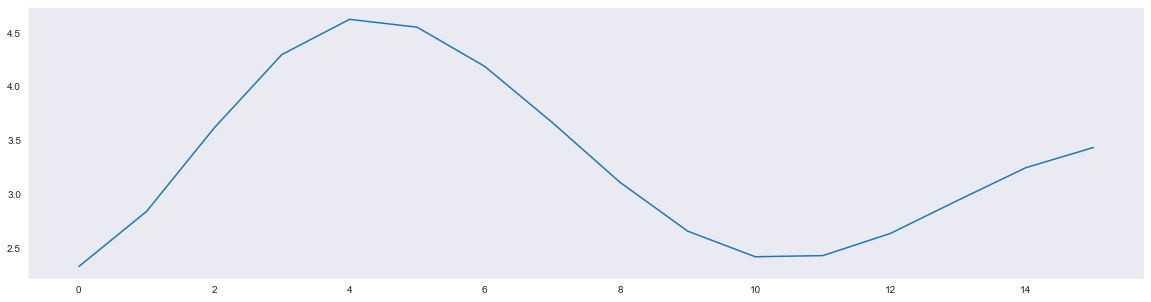

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(smooth_spikecounts(spikecounts[120], sigma=2))
plt.show()

In [118]:
fr_matrix = np.zeros(shape=(len(spikecounts), len(spikecounts[0])))
fr_matrix_meta = {}
for i, (c, spikecount) in enumerate(spikecounts.items()):
    fr_matrix[i] = spikecount#smooth_spikecounts(spikecount, sigma=2)
    fr_matrix_meta[c] = i

In [119]:
fr_matrix = (fr_matrix.T - np.mean(fr_matrix.T, axis=0)).T

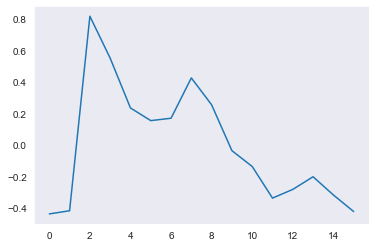

In [120]:
plt.plot(np.mean(fr_matrix, axis=0))

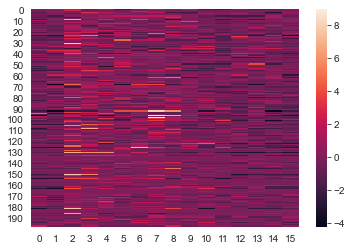

In [121]:
sb.heatmap(fr_matrix)
plt.show()

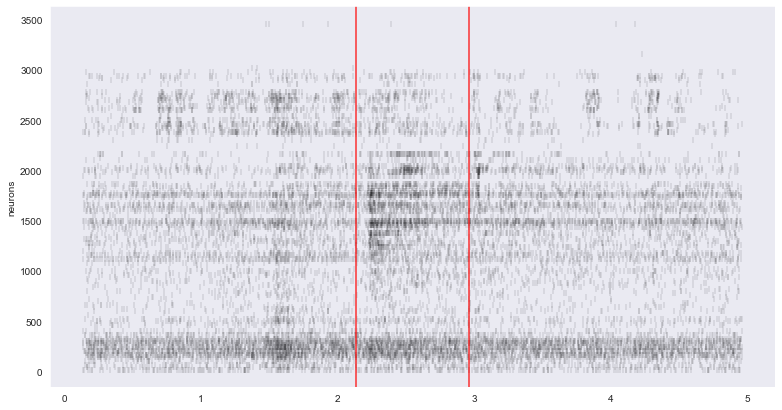

In [59]:
fig, ax = plt.subplots(figsize=(13, 7))
plot_spike_raster(clusters_good, start=63941-60000, end=88940+60000, ax=ax, event_times=[(0,63941), (1,88940)], colored=False, color_palette=color_palette, visualize_depth=True, cluster_depths=cluster_info['depth'])
plt.show()

## Clustering

Find paper that does this kind of clustering! Check retina research + Karl's paper

In [47]:
fr_matrix.shape

(199, 16)

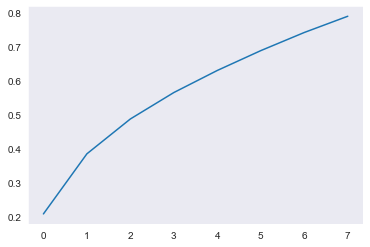

In [50]:
""" Perform PCA on spikes"""
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=8)
pca.fit(fr_matrix)
embeddings = pca.transform(fr_matrix)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [51]:
fr_matrix_reduc = pca.transform(fr_matrix)

In [52]:
fr_matrix_recon = pca.inverse_transform(fr_matrix_reduc)

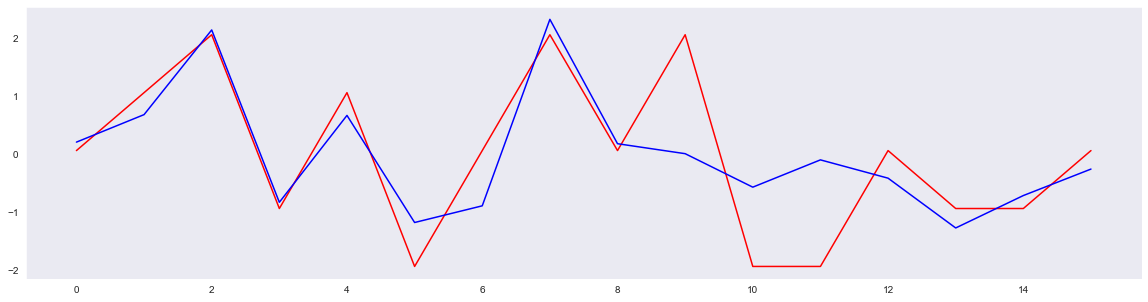

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(fr_matrix[0], c='r')
ax.plot(fr_matrix_recon[0], c='b')
plt.show()

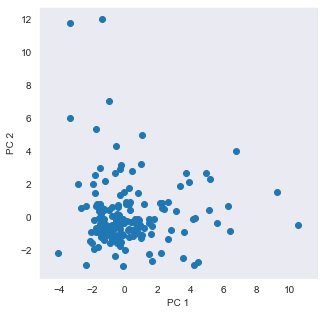

In [54]:
""" 2d plot"""
plt.figure(figsize=(5, 5))
plt.scatter(
    fr_matrix_reduc[:, 0],
    fr_matrix_reduc[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
# plt.savefig('SC_PCA_trialavg_ssc.png', dpi=100)
plt.show()

In [55]:
import umap


reducer = umap.UMAP()
embedding = reducer.fit_transform(fr_matrix_reduc)


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


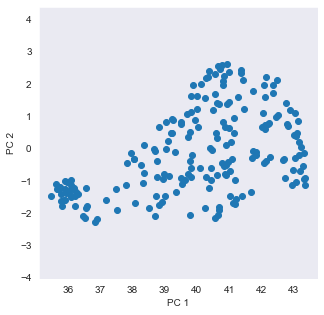

In [56]:
""" 2d plot"""
plt.figure(figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
# plt.savefig('SC_PCA_trialavg_ssc.png', dpi=100)
plt.show()

In [ ]:
# ELBOW method for deciding K in K-means
import sklearn.cluster

ssqs = []
for k in range(1, 15):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    kmeans.fit(embeddings)
    ssqs.append(kmeans.inertia_)
    
plt.plot(ssqs)

# ----------OLD----------

In [60]:
""" Check with all spiking data"""
spike_times, spike_clusters, cluster_info = (sorted_table & {'experiment_id': '01247', 'session_id': '20200328e'}).fetch1('spike_times', 'spike_clusters', 'cluster_info')

data = {}
for cluster in np.unique(spike_clusters):
    if cluster_info['group'][cluster] == 'good':# or cluster_info['group'][cluster] == 'mua':
        cl_spike_times = np.squeeze(spike_times[spike_clusters == cluster])
        data[cluster] = cl_spike_times

In [61]:
(subsess_events_table & {'experiment_id': '01247', 'session_id': '20200328e', 'subsession_type': 'OPTS'}).fetch('start_abs', 'trials_starts')

[array([0], dtype=int64),
 array([list([721334, 1322000, 1922665, 2523330, 3123995, 3724661, 4325326, 4925991, 5526656, 6127321, 6727987, 7328652, 7929317, 8529983, 9130648, 9731313, 10331978, 10932643, 11533309, 12133974, 12734639, 13335304, 13935969, 14536634, 15137299, 15737965, 16338630, 16939295, 17539960, 18140625])],
       dtype=object)]

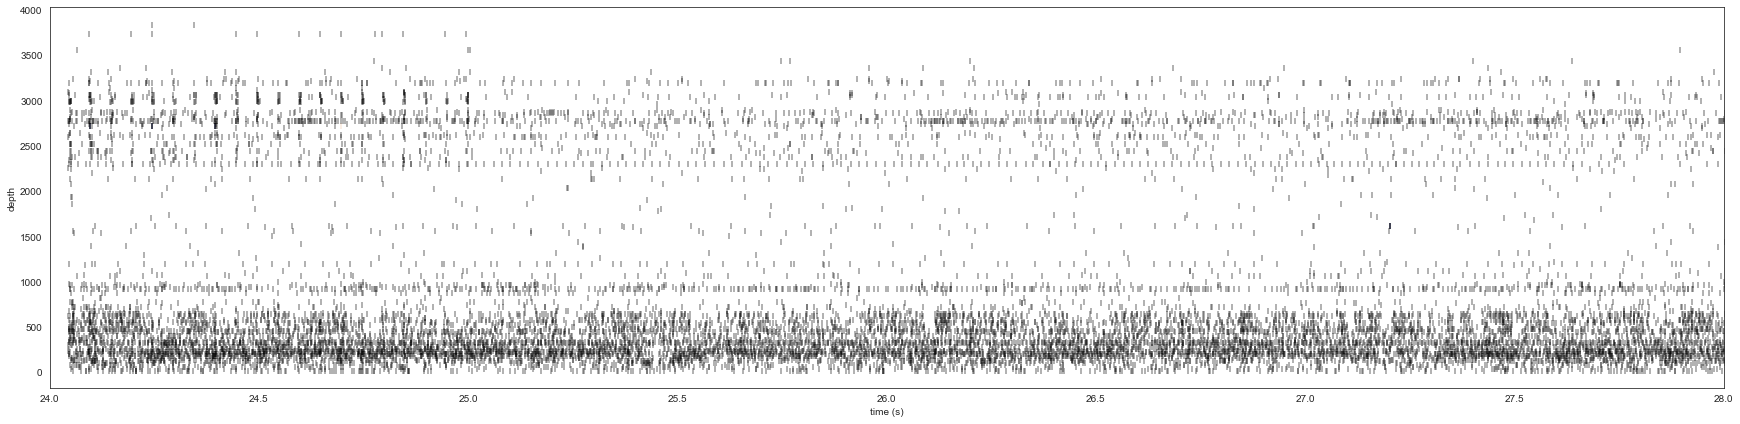

In [62]:
#9960960

fig, ax = plt.subplots(figsize=(30, 7))
plot_spike_raster(data, start=721334, end=721334+30000*10, ax=ax, event_times=None, colored=False, visualize_depth=True, cluster_depths=cluster_info['depth'])
# for trigger in subsess_triggers[7]:
#     ax.axvline((18157956+trigger)/30000, c='r')
# plt.savefig('SC_EXPA.png', dpi=200)
# plt.ylim(2000, 2600)
# plt.xlim(24, 28)
plt.show()